In [449]:
# PACKAGE IMPORTS

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
import requests
import io
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import zipfile

**Data description**

	
- pclass	Ticket class (proxy for SES)
- sex	Sex	
- Age	Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp	# of siblings / spouses aboard the Titanic. Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and fiancés were ignored)
- parch	# of parents / children aboard the Titanic. Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them.
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation

In [455]:
#I hate the fact that kaggle chooses what my train and test is. I'm concatenating them, preprocessing them together and doing
# a test train split later on down the line.
path='./train.csv'
path_test='./test.csv'

df_train=pd.read_csv(path)
df_test=pd.read_csv(path_test)
print(df.head())

    Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket Ticket_str  Ticket_dig  
0       3    male      1       0.0         A/5 21171        A/5     21171.0  
1       1  female      1       1.0          PC 17599         PC     17599.0  
2       3  female      0       1.0  STON/O2. 3101282   STON/O2.   3101282.0  
3       1  female   

In [456]:
df=pd.concat([df_train, df_test], ignore_index=True)
df.shape

(1309, 12)

In [457]:
#separate ticket number into a string and a number

def ticket_number_string_split(var):
    ''' this function takes a ticket code like C.A.29566 and returns the string and the following digits'''
    tup=var.split(' ')    
    string=tup[0]
    
    #sometimes there is no string, only digits. In this case set string to nan
    try:
        digits=tup[1]
    except IndexError:
        digits=string #for null digits - digit=string, string is nan
        string=np.nan
    
    if(digits in ['LINE', 'Basle']):
        string=digits
        digits=0
    
    sol=(float(digits), string)
    
    return sol


In [458]:
#if anyone from the pandas dev team reads this - please fix the apply function to map a tuple to 2 columns. This syntax is awkward.
df['Ticket_str'], df['Ticket_dig'] = 0, 0
df['Ticket_dig'], df['Ticket_str'] = zip(*df['Ticket'].apply(lambda x: ticket_number_string_split(x)))

In [459]:
#split cabin into letter and number

def cabin_letter_number_split(var):
    if(var == var):
        letter=str(var)[0]
        number=str(var)[1:]

        if(len(number)>3):
            #of course because data is data and data is messy, we have some extra code to write. Some cabins are chained. I'll keep the first one.
            cab_tups=str(var).split(' ')
            number=cab_tups[0][1:]
            letter=cab_tups[0][0]

            #if the preprocessing didn't work out, take the second element of the chained list
            if(len(number)<1):
                number=cab_tups[1][1:]
                letter=cab_tups[1][0]
            
            if(number == ''):
                number=0
            if(letter=='-'):
                letter=np.nan
            
            return (float(number), letter)
        
        else:
            if(number == ''):
                number=0
            if(letter=='-'):
                letter=np.nan
                
            return(float(number), letter)
    
    else:
        return(0, np.nan)
    
df['Cabin_dig'], df['Cabin_let'] = zip(*df['Cabin'].apply(lambda x: cabin_letter_number_split(x)))

In [460]:
df.fillna(-1, inplace=True)

In [461]:
discrete=['Pclass', 'Name', 'Sex', 'Ticket_str', 'Cabin', 'Embarked', 'Cabin_let']
continuous=['Age', 'Fare', 'SibSp', 'Parch', 'Ticket_dig', 'Cabin_dig']
predict=['Survived']


In [462]:
for col in continuous:
    df[col]=df[col].astype(float)

**Simple data exploration continuous variables**

- Set missing values to -20 to clearly visualize distribution. No fares or SibSp/Parch missing, 20% of ages missing (correlated with SES?)
- Mean fare 32 but high standard dev -> signs high inequality on board
- Age isn't normally distributed - unit distribution till 20, then large increase. Could create cat variable for children
- If look closely, fare has double distribution: few observations around 50

,Age,Fare,SibSp,Parch,Ticket_dig,Cabin_dig
count,1309.000000,1309.000000,1309.000000,1309.000000,1.309000e+03,1309.000000
mean,23.676600,33.269280,0.498854,0.385027,2.498722e+05,10.954163
std,17.866186,51.747562,1.041658,0.865560,5.643465e+05,26.050751
min,-1.000000,-1.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,7.000000,7.895800,0.000000,0.000000,1.350700e+04,0.000000
50%,24.000000,14.454200,0.000000,0.000000,6.530400e+04,0.000000
75%,35.000000,31.275000,1.000000,0.000000,3.470620e+05,0.000000
max,80.000000,512.329200,8.000000,9.000000,3.101317e+06,148.000000


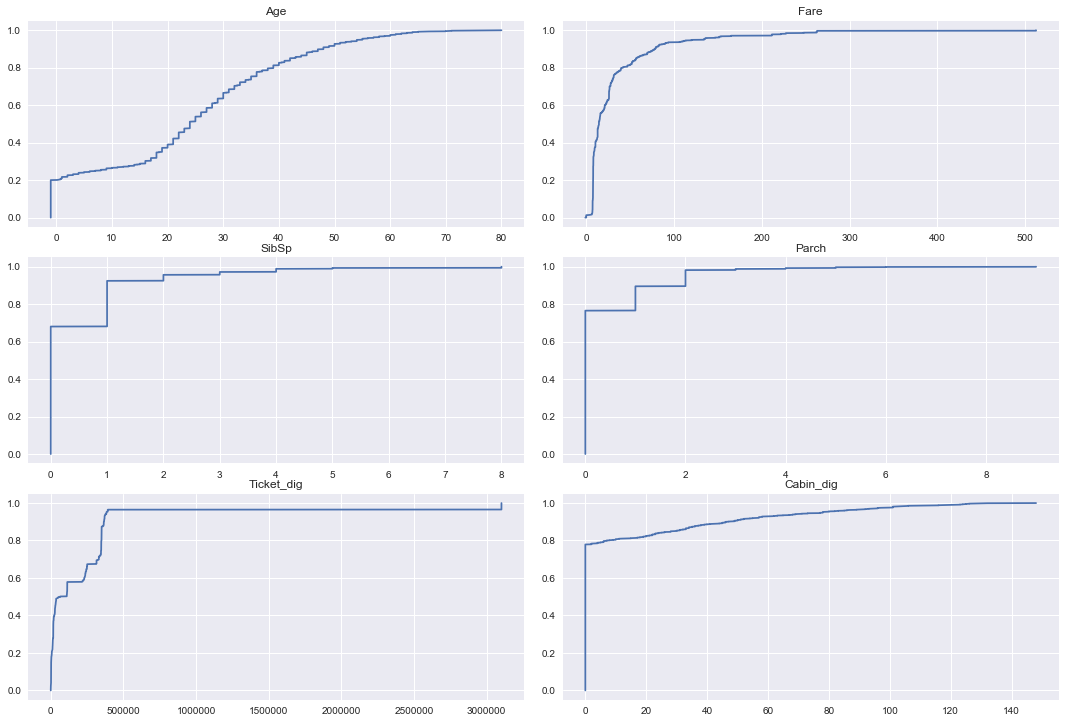

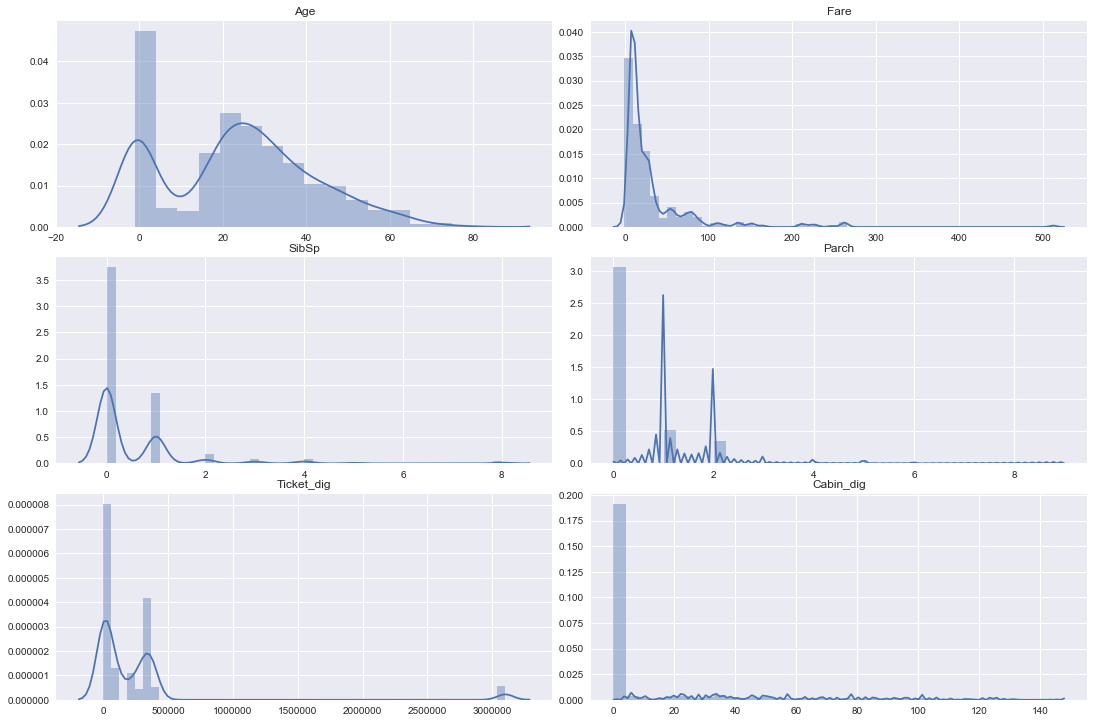

In [463]:
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.tight_layout()

for ax,i in zip(axs, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        sorted=np.sort(df[column])
        yvals=np.arange(len(sorted))/float(len(sorted))
        ax[j].plot(sorted,yvals)
        ax[j].set_title(column)
    
import seaborn as sns
import statsmodels.api as sm

fig1, axs1 = plt.subplots(3,2, figsize=(15,10))
fig1.tight_layout()

for ax, i in zip(axs1, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x=df[column][(~df[column].isnull())].values
        g=sns.distplot(x, norm_hist=True, ax=ax[j])
        g.axes.set_title(column)

df[continuous].describe()

A few observations: <br>
- Ticket dig has an uneven batch-like distribution. Since this probably doesn't have value as a continuous variable, we could bin it and feed it to the model as a categorical
- A lot of NaNs for age, cabin_dig a,d ârch less for fare


**Simple data exploration continuous variables**
- More data processing needed for ticket and cabin
- A few missing observations for embarked
- Much more males than females
- Doesn't seem like Ticket_str is giving us more information

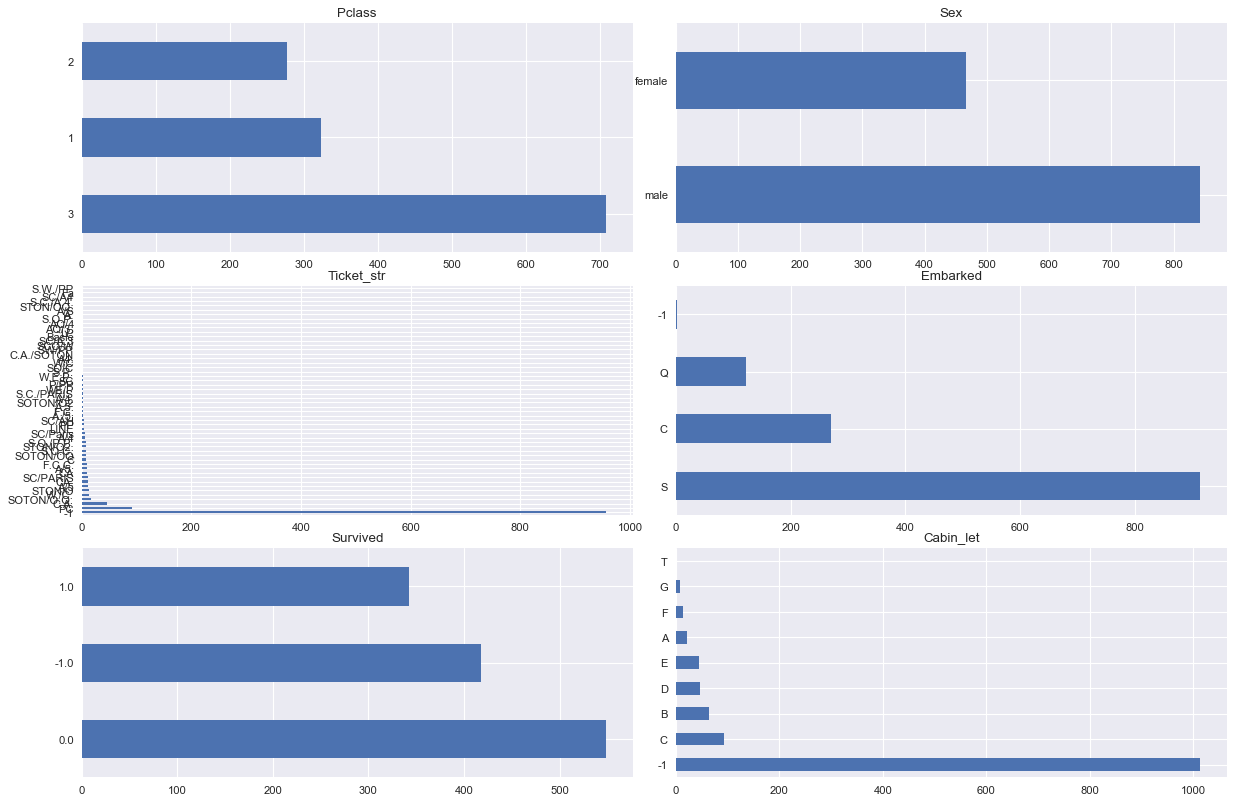

In [464]:
discrete_1=['Pclass', 'Sex', 'Ticket_str', 'Embarked', 'Survived', 'Cabin_let']

fig1, axs1 = plt.subplots(3,2, figsize=(15,10),dpi=80, squeeze=False)
fig1.tight_layout()
for ax1,n in zip(axs1, range(3)):    
    for i in range(2*n, 2*(n+1)):
        column=discrete_1[i]
        ax1[i%2].set_title(column)
        y=df[column].value_counts()
        y.plot.barh(ax=ax1[i%2])


**Correlation analysis, continuous variables**

- Age: Very interesting trends! It seems there's much more missing age values among those that didn't make it, and children dispropotionately survived -> need to create a categorical "age missing" variable
- Fare: as expected, low fares died at higher rates
- SibSp: those with families (2+) survived disproportionately
- Parch: those with parents (kids) survived at higher rates
- Ticket_number: those with low/missing ticketn numbers survived at higher rates -> categorical variable?
- Cabin_number: those who survived often had missing cabin numbers (maybe cabin numbers assigned more to lower classes)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Ticket_dig,Cabin_dig
Age,1.000000,0.213099,-0.037482,0.019879,-0.408419,-0.132220,0.000146,-0.064281,0.241216
Fare,0.213099,1.000000,0.221710,0.030889,-0.558810,0.160440,0.082111,-0.148089,0.454312
Parch,-0.037482,0.221710,1.000000,0.008942,0.018322,0.373587,0.028196,-0.017385,0.000376
PassengerId,0.019879,0.030889,0.008942,1.000000,-0.038354,-0.055224,-0.687207,-0.022501,-0.003475
Pclass,-0.408419,-0.558810,0.018322,-0.038354,1.000000,0.060832,-0.126769,0.270612,-0.574782
SibSp,-0.132220,0.160440,0.373587,-0.055224,0.060832,1.000000,0.012470,0.048927,-0.003242
Survived,0.000146,0.082111,0.028196,-0.687207,-0.126769,0.012470,1.000000,-0.038868,0.121458
Ticket_dig,-0.064281,-0.148089,-0.017385,-0.022501,0.270612,0.048927,-0.038868,1.000000,-0.140370
Cabin_dig,0.241216,0.454312,0.000376,-0.003475,-0.574782,-0.003242,0.121458,-0.140370,1.000000


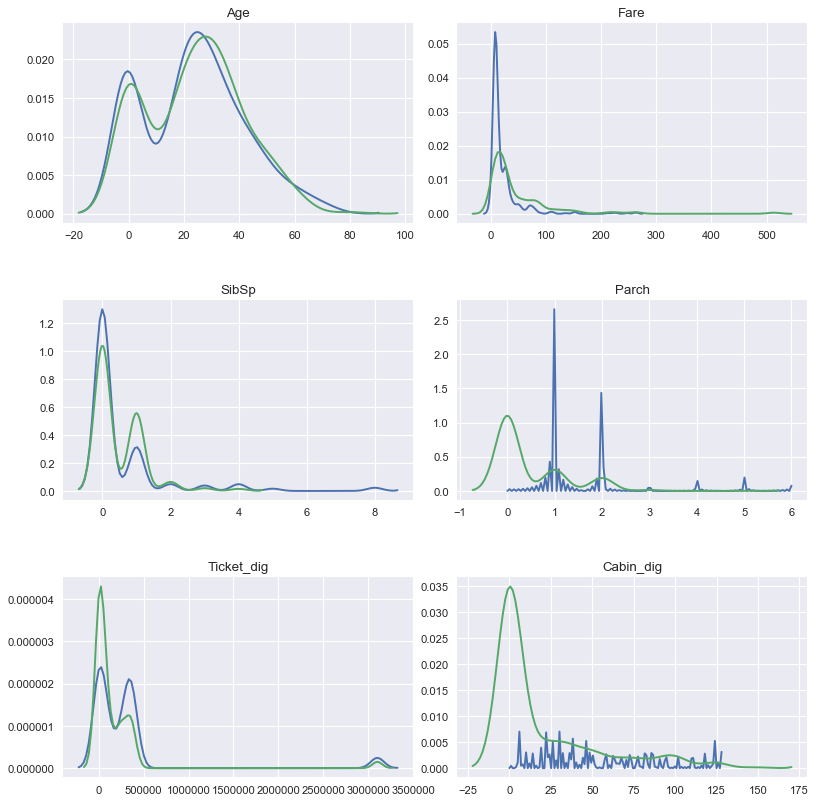

In [465]:
import warnings
warnings.filterwarnings('ignore')

subset_1=df[df['Survived']==1]
subset_0=df[df['Survived']==0]

#Which variables look interesting?
fig1, axs1 = plt.subplots(3,2, figsize=(10,10),dpi=80, squeeze=False)
fig1.tight_layout(h_pad=5.0)

for ax1,i in zip(axs1, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x0=subset_0[column].values
        x1=subset_1[column].values
        g=sns.distplot(x0,hist=False, norm_hist=False, ax=ax1[j])
        g=sns.distplot(x1,hist=False, ax=ax1[j])
        g.axes.set_title(column)

df.corr()

**Correlation analysis** <br>
I should have used bar graphs but I was time strapped and just needed a quick visualization, so this'll do. <br>

- Ticket_str can be reduced to categorical exists/doesn't exist (missing at lower rates for survivors). Probably capturing other information like SES
- Sex is interesting: women survived at much higher rates than men
- Embarked - clear relationship; those who embarked at Q much less likely to survive. Is this a wealth effect?
- Cabin letter has a strong effect

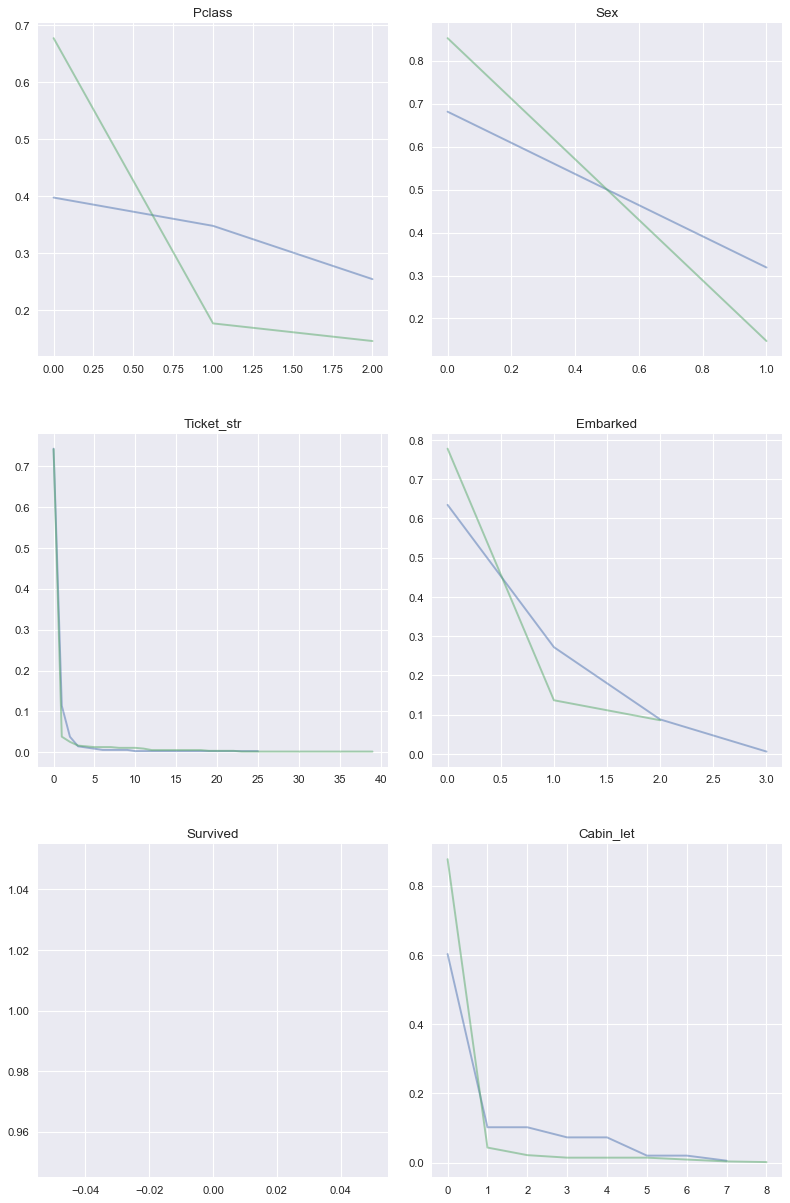

In [466]:
subset_0=df[discrete_1][df['Survived']==0]
subset_1=df[discrete_1][df['Survived']==1]

fig1, axs1 = plt.subplots(3,2, figsize=(10,15),dpi=80, squeeze=False)
fig1.tight_layout(h_pad=5.0)
for ax1,i in zip(axs1, range(3)):
    for k in range(2):
        column=discrete_1[2*i+k]
        y0=subset_0[column].value_counts()/len(subset_0)
        x0=range(len(subset_0[column].unique()))
        x1=range(len(subset_1[column].unique()))
        x_vals=subset_1[column].unique()
        y1=subset_1[column].value_counts()/len(subset_1)
        axis=ax1[k]
        axis.plot(x1,y1, alpha=0.5)
        axis.plot(x0,y0, alpha=0.5)
        axis.set_title(column)
        

In [467]:
def sumTable_cat(string, cutoff):
    x=df[[string, 'Survived']].groupby([string])
    summ=pd.concat([x.sum()/x.count(), x.count()], axis=1)
    summ.columns=['% Survived', 'count']
    print(summ[summ.iloc[:,0]>cutoff], '\n')

sumTable_cat('Sex', 0)
sumTable_cat('Cabin_let',0)

        % Survived  count
Sex                      
female     0.17382    466 

           % Survived  count
Cabin_let                   
B            0.261538     65
D            0.260870     46
E            0.318182     44
F            0.142857     14 



**More Feature engineering**
- Creating a categorical variable if a cabin letter is present or not (don't seem significantly different)
- Categorical variable if a Ticket_str is present or not
- Categorical if Parch is present or not
- Binning the ticket digit

In [468]:
# Create Mr/Mrs/title variables - credit to Ahmed Besbes' for the mapping dictionary
def get_titles():
    global df
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                        }
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
get_titles()


In [469]:
#Remove certain values, create present/not present ticket string variable
df.ix[(df.Cabin_let == 'T'),
      'Cabin_let']='Missing'

In [470]:
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_str,Ticket_dig,Cabin_dig,Cabin_let,Title
0,22.0,-1,S,7.2500,"Braund, Mr. Owen Harris",0.0,1,3,male,1.0,0.0,A/5 21171,A/5,21171.0,0.0,-1,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,2,1,female,1.0,1.0,PC 17599,PC,17599.0,85.0,C,Mrs
2,26.0,-1,S,7.9250,"Heikkinen, Miss. Laina",0.0,3,3,female,0.0,1.0,STON/O2. 3101282,STON/O2.,3101282.0,0.0,-1,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,4,1,female,1.0,1.0,113803,-1,113803.0,123.0,C,Mrs
4,35.0,-1,S,8.0500,"Allen, Mr. William Henry",0.0,5,3,male,0.0,0.0,373450,-1,373450.0,0.0,-1,Mr
5,-1.0,-1,Q,8.4583,"Moran, Mr. James",0.0,6,3,male,0.0,0.0,330877,-1,330877.0,0.0,-1,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0.0,7,1,male,0.0,0.0,17463,-1,17463.0,46.0,E,Mr
7,2.0,-1,S,21.0750,"Palsson, Master. Gosta Leonard",1.0,8,3,male,3.0,0.0,349909,-1,349909.0,0.0,-1,Master
8,27.0,-1,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2.0,9,3,female,0.0,1.0,347742,-1,347742.0,0.0,-1,Mrs
9,14.0,-1,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0.0,10,2,female,1.0,1.0,237736,-1,237736.0,0.0,-1,Mrs


In [471]:
df.ix[(df.Ticket_str != -1),
      'Ticket_str']='Present'
df.ix[(df.Ticket_str != 'Present'),
      'Ticket_str']='Not Present'

In [472]:
# Set variables to string

df['Pclass'].apply(str)
df['Cabin_let'].apply(str)
df['Embarked'].apply(str)

0       S
1       C
2       S
3       S
4       S
5       Q
6       S
7       S
8       S
9       C
10      S
11      S
12      S
13      S
14      S
15      S
16      Q
17      S
18      S
19      C
20      S
21      S
22      Q
23      S
24      S
25      S
26      C
27      S
28      Q
29      S
       ..
1279    Q
1280    S
1281    S
1282    S
1283    S
1284    S
1285    S
1286    S
1287    Q
1288    C
1289    S
1290    Q
1291    S
1292    S
1293    C
1294    S
1295    C
1296    C
1297    S
1298    C
1299    Q
1300    S
1301    Q
1302    Q
1303    S
1304    S
1305    C
1306    S
1307    S
1308    C
Name: Embarked, dtype: object

In [473]:
#value imputation for missing features

df['Embarked'][df['Embarked']==30]='Q'
df['Cabin_let'][df['Cabin_let']==-1]='Missing'

In [474]:
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_str,Ticket_dig,Cabin_dig,Cabin_let,Title
0,22.0,-1,S,7.2500,"Braund, Mr. Owen Harris",0.0,1,3,male,1.0,0.0,A/5 21171,Present,21171.0,0.0,Missing,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,2,1,female,1.0,1.0,PC 17599,Present,17599.0,85.0,C,Mrs
2,26.0,-1,S,7.9250,"Heikkinen, Miss. Laina",0.0,3,3,female,0.0,1.0,STON/O2. 3101282,Present,3101282.0,0.0,Missing,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,4,1,female,1.0,1.0,113803,Not Present,113803.0,123.0,C,Mrs
4,35.0,-1,S,8.0500,"Allen, Mr. William Henry",0.0,5,3,male,0.0,0.0,373450,Not Present,373450.0,0.0,Missing,Mr
5,-1.0,-1,Q,8.4583,"Moran, Mr. James",0.0,6,3,male,0.0,0.0,330877,Not Present,330877.0,0.0,Missing,Mr
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0.0,7,1,male,0.0,0.0,17463,Not Present,17463.0,46.0,E,Mr
7,2.0,-1,S,21.0750,"Palsson, Master. Gosta Leonard",1.0,8,3,male,3.0,0.0,349909,Not Present,349909.0,0.0,Missing,Master
8,27.0,-1,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2.0,9,3,female,0.0,1.0,347742,Not Present,347742.0,0.0,Missing,Mrs
9,14.0,-1,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0.0,10,2,female,1.0,1.0,237736,Not Present,237736.0,0.0,Missing,Mrs


Binning ticket digit

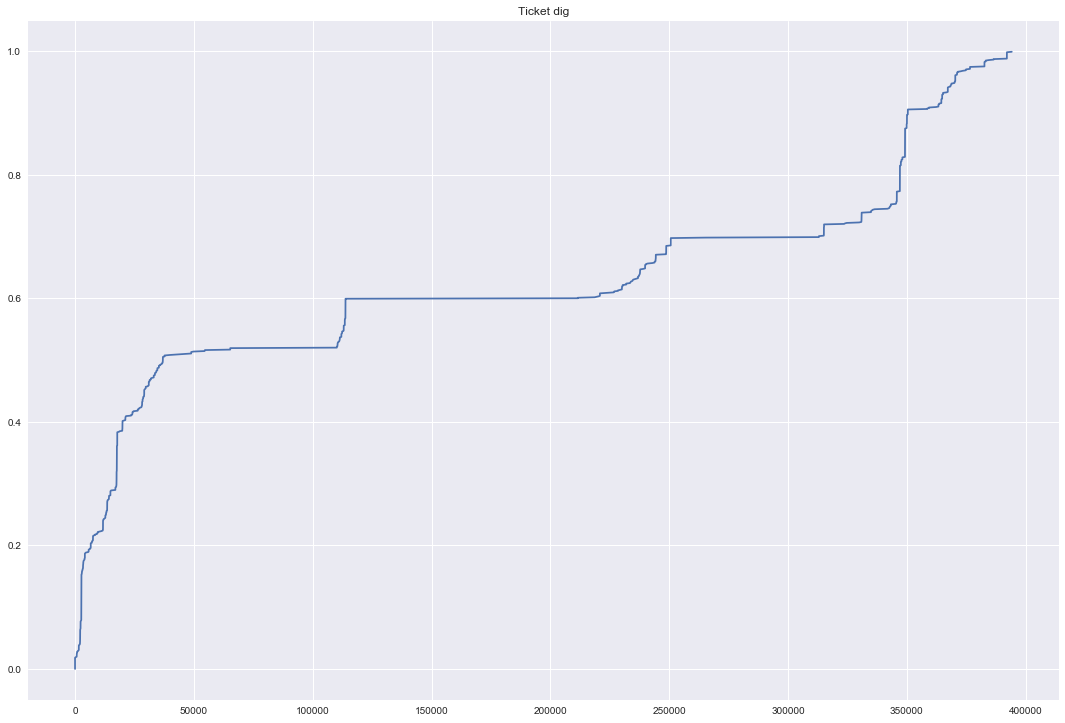

In [475]:
fig, axs = plt.subplots(1,1, figsize=(15,10))
fig.tight_layout()
sub=df['Ticket_dig'][df['Ticket_dig']<500000]
sorted=np.sort(sub)
yvals=np.arange(len(sorted))/float(len(sorted))
axs.plot(sorted,yvals)
axs.set_title('Ticket dig')

In [476]:
#binning ticket digit. I used the histogram above.
def bin_ticket_dig(var):
    if(var < 15000):
        return 1
    elif(var < 50000):
        return 2
    elif(var < 260000):
        return 3
    elif(var < 360000):
        return 4
    else:
        return 5

df['Ticket_dig_binned']=df['Ticket_dig'].apply(bin_ticket_dig)

In [477]:
df['Ticket_dig_binned'].value_counts()


1    365
2    285
4    267
3    232
5    160
Name: Ticket_dig_binned, dtype: int64

In [478]:
df

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Ticket_str,Ticket_dig,Cabin_dig,Cabin_let,Title,Ticket_dig_binned
0,22.0,-1,S,7.2500,"Braund, Mr. Owen Harris",0.0,1,3,male,1.0,0.0,A/5 21171,Present,21171.0,0.0,Missing,Mr,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,2,1,female,1.0,1.0,PC 17599,Present,17599.0,85.0,C,Mrs,2
2,26.0,-1,S,7.9250,"Heikkinen, Miss. Laina",0.0,3,3,female,0.0,1.0,STON/O2. 3101282,Present,3101282.0,0.0,Missing,Miss,5
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,4,1,female,1.0,1.0,113803,Not Present,113803.0,123.0,C,Mrs,3
4,35.0,-1,S,8.0500,"Allen, Mr. William Henry",0.0,5,3,male,0.0,0.0,373450,Not Present,373450.0,0.0,Missing,Mr,5
5,-1.0,-1,Q,8.4583,"Moran, Mr. James",0.0,6,3,male,0.0,0.0,330877,Not Present,330877.0,0.0,Missing,Mr,4
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0.0,7,1,male,0.0,0.0,17463,Not Present,17463.0,46.0,E,Mr,2
7,2.0,-1,S,21.0750,"Palsson, Master. Gosta Leonard",1.0,8,3,male,3.0,0.0,349909,Not Present,349909.0,0.0,Missing,Master,4
8,27.0,-1,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2.0,9,3,female,0.0,1.0,347742,Not Present,347742.0,0.0,Missing,Mrs,4
9,14.0,-1,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0.0,10,2,female,1.0,1.0,237736,Not Present,237736.0,0.0,Missing,Mrs,3


NaN imputation for variables still not binned. Checking I didn't miss any for variables I'm not sure about. I could have done this with a function if I had more features

In [479]:
df.loc[df['Age']==-1, 'Age']=df['Age'].median()

In [480]:
df.loc[df['Fare']==-1, 'Fare']=df['Fare'].median()

In [481]:
df.loc[df['Embarked']==-1, 'Embarked']=df['Embarked'].mode()

In [482]:
for x in df:
    print(x, len(df[df[x]==-1]))

Age 0
Cabin 1014
Embarked 0
Fare 0
Name 0
Parch 0
PassengerId 0
Pclass 0
Sex 0
SibSp 0
Survived 418
Ticket 0
Ticket_str 0
Ticket_dig 0
Cabin_dig 0
Cabin_let 0
Title 0
Ticket_dig_binned 0


**Building a random forest model** <br>
Our sample size is too small for a GBM, and we may have several interaction relationships that we would like to pick up (ie a poor woman is fundamentally different from a rich woman in her probability of surviving). We're going to try random forest (decision tree could overfit, especially for such a small dataset).

In [483]:
#Note I removed cabin_str since it turned out later it was only adding noise to our model.
discrete_feat=['Pclass', 'Sex', 'Embarked', 'Ticket_str', 'Title', 'Ticket_dig_binned']
continuous_feat=['Age', 'Fare', 'SibSp', 'Parch', 'Ticket_dig', 'Cabin_dig']
predict=['Survived']
ids=['PassengerId']

In [484]:
#categorical variable encoding
cat=df[discrete_feat]

for col in cat:
    cat[col]=cat[col].astype(str)

cat_dummies=pd.get_dummies(cat, drop_first=True)
#29 binary features - maybe too much?

In [502]:
#Test/submission split
x_total=x_train=pd.concat([cat_dummies, df[continuous_feat], df[predict], df[ids]], axis=1)
x=x_total[x_total['Survived']!=-1]
x_submit=x_total[x_total['Survived']==-1]

In [504]:
#setting up cross validation
x['fold']=np.random.choice(range(1, 6), x.shape[0])

In [487]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
features=[ft for ft in x.columns if ft in cat_dummies.columns or ft in continuous_feat]
print(features)

['Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Embarked_nan', 'Ticket_str_Present', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Ticket_dig_binned_2', 'Ticket_dig_binned_3', 'Ticket_dig_binned_4', 'Ticket_dig_binned_5', 'Age', 'Fare', 'SibSp', 'Parch', 'Ticket_dig', 'Cabin_dig']


In [568]:
#random forest with 5 fold cross validation. If I wanted to be picky I would have used H2O that handles categoricals better.
trainpreds={}
testpreds={}

for i in range(1,6):
    #set up train/test datasets, ids and targets
    train=x[x['fold']!=i]
    test=x[x['fold']==i]
    train_ids=train['PassengerId'].values
    test_ids=test['PassengerId'].values
    train_features=train[features]
    test_features=test[features]
    train_target=train[predict].values
    test_target=test[predict].values
    
    #fit forrest, get predictions
    ranFor = RandomForestClassifier(n_estimators=1000, bootstrap= True, criterion= 'entropy',
                                    max_depth=3, max_features= 5, min_samples_leaf= 3, min_samples_split= 10)
    ranFor.fit(train_features,train_target)
    predicted_train=[[int(z), y[1]] for y,z in zip(ranFor.predict_proba(train_features), train_target)]
    predicted_test=[[int(z), y[1]] for y,z in zip(ranFor.predict_proba(test_features), test_target)]
    
    #save in dicts. The first element is the true value.
    for pid, pred in zip(test_ids, predicted_test):
        testpreds[pid]=pred
    
    for pid, pred in zip(train_ids, predicted_train):
        if pid in trainpreds:
            trainpreds[pid]=trainpreds[pid]+[pred[1]]
        else:
            trainpreds[pid]=pred


In [569]:
testpreds

{1: [0, 0.15257637622601103],
 2: [1, 0.89326398599087631],
 3: [1, 0.49535533979758539],
 4: [1, 0.85565825157148823],
 5: [0, 0.12006993698502089],
 6: [0, 0.13350940844183057],
 7: [0, 0.38074608520408637],
 8: [0, 0.3156032568201505],
 9: [1, 0.45508188866079918],
 10: [1, 0.7838022612709401],
 11: [1, 0.69602168345553161],
 12: [1, 0.79214953080261985],
 13: [0, 0.16204388067579595],
 14: [0, 0.15950897530563829],
 15: [0, 0.5359302677622414],
 16: [1, 0.76849225324713166],
 17: [0, 0.31453085536612407],
 18: [1, 0.16639109486841122],
 19: [0, 0.51836191859514769],
 20: [1, 0.60244125484787536],
 21: [0, 0.19465504658576499],
 22: [1, 0.22170238082899707],
 23: [1, 0.56774520134842621],
 24: [1, 0.2983431899069186],
 25: [0, 0.45555635887408891],
 26: [1, 0.44627043587752219],
 27: [0, 0.14286690790055773],
 28: [0, 0.36287410570473266],
 29: [1, 0.5480385780648096],
 30: [0, 0.11715377251430914],
 31: [0, 0.46989175751705464],
 32: [1, 0.90461111113339654],
 33: [1, 0.59324780008

In [570]:
trainpreds

{1: [0,
  0.14513220607633001,
  0.1358231489516851,
  0.14177380022341926,
  0.14776199360949183],
 2: [1,
  0.88961130563481639,
  0.90439879118852284,
  0.90441274878361833,
  0.884506513103126],
 3: [1,
  0.58424040289336199,
  0.54429242174367898,
  0.57663278226047943,
  0.53269925559180997],
 4: [1,
  0.83888103726643914,
  0.84515696217729075,
  0.86645527133554212,
  0.83546301214485963],
 5: [0,
  0.12036157975058676,
  0.12963867112378741,
  0.12807673021063953,
  0.12328533554943208],
 6: [0,
  0.1253878967112648,
  0.12870752386207279,
  0.14009285041327457,
  0.14330276582045018],
 7: [0,
  0.34355831877558102,
  0.33759570860316601,
  0.34017803763505544,
  0.34158530997858066],
 8: [0,
  0.31837002194648878,
  0.31838559650074599,
  0.33123415956879654,
  0.30822530149789867],
 9: [1,
  0.54816891274545743,
  0.49345268833573669,
  0.51413022142055065,
  0.49871898282359362],
 10: [1,
  0.79245947504519598,
  0.79015166533614078,
  0.78252566024257564,
  0.7962915856513

In [571]:
trainpreds_average={i : [y[0], sum(y[1:])/len(y[1:])] for i,y in trainpreds.items()}

<b> Validation

In [572]:
train_true=[z[0] for z in trainpreds_average.values()]
train_raw=[z[1] for z in trainpreds_average.values()]
train_pred=[round(z[1]) for z in trainpreds_average.values()]
test_true=[z[0] for z in testpreds.values()]
test_raw=[z[1] for z in testpreds.values()]
test_pred=[round(z[1]) for z in testpreds.values()]

In [573]:
#test on training set average predictions
from sklearn import metrics
matrix_train=metrics.confusion_matrix(train_true, train_pred)
print('train confusion matrix: \n', matrix_train)

matrix_test=metrics.confusion_matrix(test_true, test_pred)
print('test confusion matrix: \n', matrix_test)

train confusion matrix: 
 [[494  55]
 [ 99 243]]
test confusion matrix: 
 [[485  64]
 [106 236]]


In [574]:
print(metrics.classification_report(train_true, train_pred))
print(metrics.classification_report(test_true, test_pred))

             precision    recall  f1-score   support

          0       0.83      0.90      0.87       549
          1       0.82      0.71      0.76       342

avg / total       0.83      0.83      0.82       891

             precision    recall  f1-score   support

          0       0.82      0.88      0.85       549
          1       0.79      0.69      0.74       342

avg / total       0.81      0.81      0.81       891



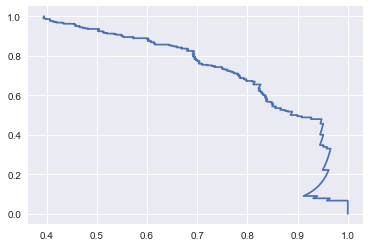

In [575]:
#test precision recall curve
p_recall=metrics.precision_recall_curve(test_true, test_raw)
plt.plot(p_recall[0], p_recall[1])
plt.show()

Feature importance (using my last model as a rough estimate). The key learning here is that cabin letters are not contributing at all, and just adding noise to the model. I'll remove these. Whether the ticket string is present also doesn't help.

In [576]:
ft_imp={}
for ft, imp in zip(train_features.columns, ranFor.feature_importances_):
    ft_imp[ft]=imp

for x in ft_imp.items():
    print(x)

('Pclass_2', 0.0073588070233725445)
('Pclass_3', 0.081408176037509911)
('Sex_male', 0.21876667323125029)
('Embarked_Q', 0.0044058653326641516)
('Embarked_S', 0.0063135213620819077)
('Embarked_nan', 0.0)
('Ticket_str_Present', 0.0011227509716749907)
('Title_Miss', 0.064944122518437036)
('Title_Mr', 0.25992063345996108)
('Title_Mrs', 0.062771427707465965)
('Title_Officer', 0.0026429843313995789)
('Title_Royalty', 0.00015228636486200716)
('Ticket_dig_binned_2', 0.022042586074150314)
('Ticket_dig_binned_3', 0.0026671030141401262)
('Ticket_dig_binned_4', 0.016206794584049632)
('Ticket_dig_binned_5', 0.0028789834598747744)
('Age', 0.029496039981463801)
('Fare', 0.082698291250110842)
('SibSp', 0.025353162293605663)
('Parch', 0.0054914743218160049)
('Ticket_dig', 0.058626834359721117)
('Cabin_dig', 0.044731482320388136)


Grid search

In [577]:
x_gd=x.loc[x['fold']!=5, features]
y_gd=x.loc[x['fold']!=5, predict].values

AttributeError: 'tuple' object has no attribute 'loc'

In [578]:
y_gd=y_gd.reshape(701,)

In [579]:
#used grid search code from sklearn website.
print(__doc__)

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# use a full grid over all parameters
param_grid = {"max_depth": [None],
              "max_features": [3, 5, 10],
              "min_samples_split": [3, 10],
              "min_samples_leaf": [1, 3],
              "bootstrap": [True, False],
              "criterion": ["entropy"]}

# run grid search
grid_search = GridSearchCV(ranFor, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(x_gd, y_gd)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

Automatically created module for IPython interactive environment


KeyboardInterrupt: 

<b> Final export

In [584]:
y_pred=ranFor.predict(x_submit[features])
y_pred_ids=x_submit['PassengerId'].values
output = {'Survived':y_pred}
df_output=pd.DataFrame(data=output, index=y_pred_ids, columns=['Survived'])
df_output.index.name='PassengerId'
df_output['Survived']=df_output['Survived'].astype(int)

In [586]:
df_output.to_csv('output.csv')

In [587]:
df_output

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
